**Autoencoder (AE)**
---
**Imports**

---

External libraries required for operation

In [1]:
import json
import os
import datetime
import numpy as np
import matplotlib.pyplot as plt
from data_manager import data_preprocessor as preproc
from data_manager import fixed_splitter as fs
from model_manager import model_generator, model_trainer, model_storage
from model_manager import model_evaluation
from grapher import graph_generator as gg

Opening the trainer_config.json file, which contains all of the trianing hyperparameter information

In [2]:
TRAINER_CONFIG_FILE_LOCATION = 'config/trainer_config.json'
model_type = 'AE'
with open(TRAINER_CONFIG_FILE_LOCATION, 'r') as file:
    train_config = json.load(file)

**Data Preprocessing & Splitting**

---

Here we preprocess and split the background data into testing, validation, and training groups. The background and signal data is also normalized here.

In [3]:
# creating numpy arrays filled with the data
preprocessed_data = preproc.get_data(train_config) # gets background data by default
Ato4l = preproc.get_data(train_config, "Ato4l_lepFilter_13TeV")
hToTauTau = preproc.get_data(train_config, "hToTauTau_13TeV_PU20")
hChToTauNu = preproc.get_data(train_config, "hChToTauNu_13TeV_PU20")
leptoquark = preproc.get_data(train_config, "leptoquark_LOWMASS_lepFilter_13TeV")

# normalizing the data
Ato4l = preproc.normalize_data(Ato4l)
hToTauTau = preproc.normalize_data(hToTauTau)
hChToTauNu = preproc.normalize_data(hChToTauNu)
leptoquark = preproc.normalize_data(leptoquark)

# concatenating the signal data into one big array
signal_data = np.concatenate([
    Ato4l, 
    hToTauTau,
    hChToTauNu,
    leptoquark
])

#splitting background data into training, validation, and testing groups
data_train, data_validate, data_test = fs.generate_fixed_trainingdata_split(train_config, preprocessed_data, True)

Generated The Following Datasets
 Train Data Shape : (2000000, 57)
 Validation Data Shape : (399999, 57)
 Test Data Shape : (50000, 57)


**Model Initialization**

---

Initialize an AE model object

In [4]:
model = model_generator.create_model(train_config, model_type)

2025-07-25 15:08:04.601033: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 57)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_32 (Dense)              │ (None, 32)             │         1,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_16 (Dense)              │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent (Dense)                  │ (None, 2)              │            34 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,418 (9.45 KB)

 Trainable params: 2,418 (9.45 KB)

 Non-trainable params: 0 (0.00 B)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │            48 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 57)             │         1,881 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,473 (9.66 KB)

 Trainable params: 2,473 (9.66 KB)

 Non-trainable params: 0 (0.00 B)

**Model Training**

---

Training model generic
Epoch 1/20
1954/1954 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 0.2263 - val_loss: 0.1667 - learning_rate: 0.0010
Epoch 2/20
1954/1954 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 0.1662 - val_loss: 0.1648 - learning_rate: 0.0010
Epoch 3/20
1954/1954 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 0.1650 - val_loss: 0.1640 - learning_rate: 0.0010
Epoch 4/20
1954/1954 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 0.1640 - val_loss: 0.1636 - learning_rate: 0.0010
Epoch 5/20
1954/1954 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 0.1639 - val_loss: 0.1634 - learning_rate: 0.0010
Epoch 6/20
1954/1954 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 0.1635 - val_loss: 0.1632 - learning_rate: 0.0010
Epoch 7/20
1954/1954 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 0.1633 - val_loss: 0.1630 - learning_rate: 0.0010
Epoch 8/20
1954/1954 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 0.1632 - val_loss: 0.1630 - learning_rate: 0.0010
Epoch 9/20
1954/1954 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 0.1632 - val_loss:

/sdf/home/b/begeldan/evidential-dl-ae/grapher/graph_generator.py:21: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='upper right')


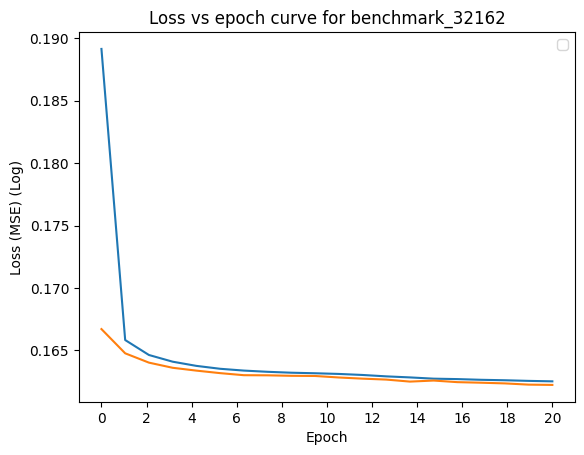

In [5]:
model, history = model_trainer.train_model(train_config, model, data_train, data_validate)
gg.generate_loss_vs_epoch(train_config, history, model_type)

**Model Evaluation**

---

Calculating the loss on signal data and testing data. We will use this to evaluate the model

In [6]:
# # use the model to reconstruct the background test data and different signal datasets
# reconstructed_background = model(data_test).numpy()
# reconstructed_Ato4l = model(Ato4l).numpy()
# reconstructed_hToTauTau = model(hToTauTau).numpy()
# reconstructed_hChToTauNu = model(hChToTauNu).numpy()
# reconstructed_leptoquark = model(leptoquark).numpy()


# # calculate MSE
# background_scores = ((reconstructed_background-data_test)**2)
# Ato4l_scores = ((reconstructed_Ato4l - Ato4l)**2)
# hToTauTau_scores = ((reconstructed_hToTauTau - hToTauTau)**2)
# hChToTauNu_scores = ((reconstructed_hChToTauNu - hChToTauNu)**2)
# leptoquark_scores = ((reconstructed_leptoquark - leptoquark)**2)


# # Average out the MSE (since the output and input are 57-dimensional vectorss)
# background_scores = np.mean(background_scores,axis=1,keepdims=True)
# Ato4l_scores = np.mean(Ato4l_scores,axis=1,keepdims=True)
# hToTauTau_scores = np.mean(hToTauTau_scores,axis=1,keepdims=True)
# hChToTauNu_scores = np.mean(hChToTauNu_scores,axis=1,keepdims=True)
# leptoquark_scores = np.mean(leptoquark_scores,axis=1,keepdims=True)


background_scores = model_evaluation.calculate_loss(train_config, model, data_test, model_type)
Ato4l_scores = model_evaluation.calculate_loss(train_config, model, Ato4l, model_type)
hToTauTau_scores = model_evaluation.calculate_loss(train_config, model, hToTauTau, model_type)
hChToTauNu_scores = model_evaluation.calculate_loss(train_config, model, hChToTauNu, model_type)
leptoquark_scores = model_evaluation.calculate_loss(train_config, model, leptoquark, model_type)

# background_scores = background_scores[:50000]
# Ato4l_scores = Ato4l_scores[:50000]
# hToTauTau_scores = hToTauTau_scores[:50000]
# hChToTauNu_scores = hChToTauNu_scores[:50000]
# leptoquark_scores = leptoquark_scores[:50000]




Generate ROC and loss histograms, seeing if we can get that anomaly score to work...

In [7]:
# gg.generate_roc_curve(train_config, truth_values, scores) # TODO feed in signal and background data, have the function appoint truth values!


Loss frequency plots...

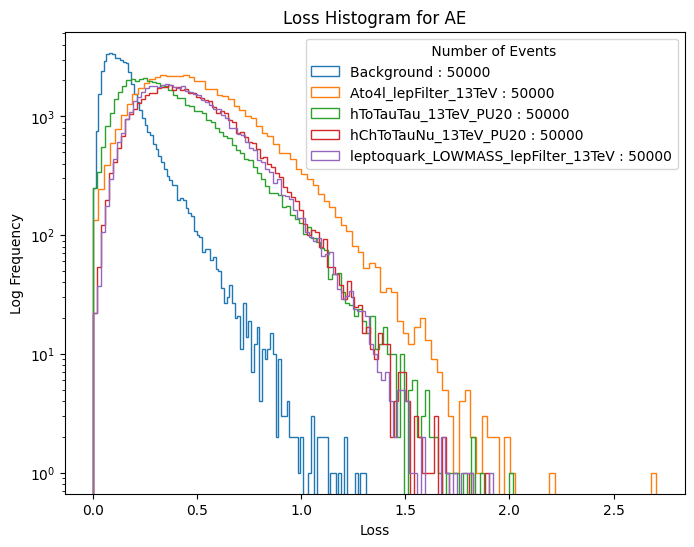

In [8]:
plt.figure(figsize=(8, 6))
plt.hist(background_scores, histtype='step',bins=train_config["outputs"]["bins"], label='Background : {}'.format(len(background_scores)))
plt.hist(Ato4l_scores, histtype='step',bins=train_config["outputs"]["bins"], label='Ato4l_lepFilter_13TeV : {}'.format(len(Ato4l_scores)))
plt.hist(hToTauTau_scores, histtype='step', bins=train_config["outputs"]["bins"], label='hToTauTau_13TeV_PU20 : {}'.format(len(hToTauTau_scores)))
plt.hist(hChToTauNu_scores, histtype='step', bins=train_config["outputs"]["bins"], label='hChToTauNu_13TeV_PU20 : {}'.format(len(hChToTauNu_scores)))
plt.hist(leptoquark_scores,histtype='step', bins = train_config["outputs"]["bins"], label='leptoquark_LOWMASS_lepFilter_13TeV : {}'.format(len(leptoquark_scores)))
plt.xlabel('Loss')
plt.ylabel('Log Frequency')
plt.yscale('log')
plt.title("Loss Histogram for AE")
plt.legend(title=" Number of Events")
plt.savefig(os.path.join(train_config["outputs"]["graph_directory"], datetime.datetime.now().strftime(
        train_config["outputs"]["date_time_format"]) + "_" + model_type + "_Histogram.png"), format="png", bbox_inches="tight")
plt.show()

In [9]:
# TODO
# Save model if it is interesting